# Collaboration and Competition

---

In this notebook, you will learn how to use the Unity ML-Agents environment for the third project of the [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893) program.

## Start the Environment

We begin by importing the necessary packages.  If the code cell below returns an error, please revisit the project instructions to double-check that you have installed [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) and [NumPy](http://www.numpy.org/).

In [1]:
from unityagents import UnityEnvironment
import numpy as np

Next, we will start the environment!  **_Before running the code cell below_**, change the `file_name` parameter to match the location of the Unity environment that you downloaded.

- **Mac**: `"path/to/Tennis.app"`
- **Windows** (x86): `"path/to/Tennis_Windows_x86/Tennis.exe"`
- **Windows** (x86_64): `"path/to/Tennis_Windows_x86_64/Tennis.exe"`
- **Linux** (x86): `"path/to/Tennis_Linux/Tennis.x86"`
- **Linux** (x86_64): `"path/to/Tennis_Linux/Tennis.x86_64"`
- **Linux** (x86, headless): `"path/to/Tennis_Linux_NoVis/Tennis.x86"`
- **Linux** (x86_64, headless): `"path/to/Tennis_Linux_NoVis/Tennis.x86_64"`

For instance, if you are using a Mac, then you downloaded `Tennis.app`.  If this file is in the same folder as the notebook, then the line below should appear as follows:
```
env = UnityEnvironment(file_name="Tennis.app")
```

In [2]:
env = UnityEnvironment(file_name="Tennis_Windows_x86_64/Tennis.exe")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

## Examine the State and Action Spaces

In this environment, two agents control rackets to bounce a ball over a net. If an agent hits the ball over the net, it receives a reward of +0.1.  If an agent lets a ball hit the ground or hits the ball out of bounds, it receives a reward of -0.01.  Thus, the goal of each agent is to keep the ball in play.

The observation space consists of 8 variables corresponding to the position and velocity of the ball and racket. Two continuous actions are available, corresponding to movement toward (or away from) the net, and jumping. 

Run the code cell below to print some information about the environment.

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents 
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:\n', states[0])

Number of agents: 2
Size of each action: 2
There are 2 agents. Each observes a state with length: 24
The state for the first agent looks like:
 [ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.         -6.65278625 -1.5
 -0.          0.          6.83172083  6.         -0.          0.        ]


## Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agents and receive feedback from the environment.

Once this cell is executed, you will watch the agents' performance, if they select actions at random with each time step.  A window should pop up that allows you to observe the agents.

Of course, as part of the project, you'll have to change the code so that the agents are able to use their experiences to gradually choose better actions when interacting with the environment!

In [5]:
for i in range(1, 6):                                      # play game for 5 episodes
    env_info = env.reset(train_mode=False)[brain_name]     # reset the environment    
    states = env_info.vector_observations                  # get the current state (for each agent)
    scores = np.zeros(num_agents)                          # initialize the score (for each agent)
    while True:
        actions = np.random.randn(num_agents, action_size) # select an action (for each agent)
        actions = np.clip(actions, -1, 1)                  # all actions between -1 and 1
        env_info = env.step(actions)[brain_name]           # send all actions to tne environment
        next_states = env_info.vector_observations         # get next state (for each agent)
        rewards = env_info.rewards                         # get reward (for each agent)
        dones = env_info.local_done                        # see if episode finished
        scores += env_info.rewards                         # update the score (for each agent)
        states = next_states                               # roll over states to next time step
        if np.any(dones):                                  # exit loop if episode finished
            break
    print('Score (max over agents) from episode {}: {}'.format(i, np.max(scores)))

Score (max over agents) from episode 1: 0.0
Score (max over agents) from episode 2: 0.0
Score (max over agents) from episode 3: 0.0
Score (max over agents) from episode 4: 0.0
Score (max over agents) from episode 5: 0.10000000149011612


When finished, you can close the environment.

## Training of MADDPG agent

A simple MADDPG agent is used to train the two Agents (tennis rackets) for a collaborative game play. The algorithm uses the actor-critic-methode where generally the critic estimates a value function and the actor updates the policy in the direction recommended by the critc. The actor as well as the critic use a local and a target NN. The local NNs are trained by samples from the replay buffer. The weights of the target NN are updated after a certain number of iterations with a soft-update. This improves learning stability compared to a hard-update (one-to-one copy). 

The algorithm includes the following features:
- replay buffer: saves experience in tuples and reuses them randomly if enough samples are available.
- batch normalization: the previous projects showed that there seems to be an improvement in the learning process.
- global defined parameters: instead of pushing parameters through the different layers of functions, they're initialy defined an reused in every function.


In [6]:
import random
import torch
from collections import deque
import matplotlib.pyplot as plt
import MADDPGagent 
import importlib
from param import param

In [7]:
# Initialize parameters
Param= param()
Param.seed=20
Param.device = 'cpu' #torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
Param.target_score = 0.5
Param.max_episodes = 2000
Param.max_t=1000

Param.num_agents = num_agents
Param.action_size = action_size
Param.state_size = state_size

Param.actor_layers = [64, 32]
Param.critic_layers = [64, 32]
Param.actor_lr = 5e-3
Param.critic_lr = 5e-3
Param.weight_decay = 0
Param.update_every = 2

Param.buffer_size = int(5e6)
Param.batch_size = 256
Param.gamma = 0.99
Param.tau = 5e-3

Param.noise_start=0.5
Param.t_stop_noise=30000
Param.noise = True
Param.noise_theta = 0.9
Param.noise_sigma = 0.01

In [8]:
importlib.reload(MADDPGagent)
agent = MADDPGagent.maddpgAGENT()

In [9]:
scores = []
scores_deque = deque(maxlen=100)
scores_avg = []

for i_episode in range(1, Param.max_episodes+1):
    rewards = []
    env_info = env.reset(train_mode=True)[brain_name]    # reset the environment    
    state = env_info.vector_observations                  # get the current state (for each agent)

    # loop over steps
    for t in range(Param.max_t):
        # select an action
        action = agent.act(state)
        # take action in environment and set parameters to new values
        env_info = env.step(action)[brain_name]
        next_state = env_info.vector_observations
        rewards_vec = env_info.rewards
        done = env_info.local_done
        # update and train agent with returned information
        agent.step(state, action, rewards_vec, next_state, done)
        state = next_state
        rewards.append(rewards_vec)
        if any(done):
            break

    # calculate episode reward as maximum of individually collected rewards of agents
    episode_reward = np.max(np.sum(np.array(rewards),axis=0))
        
    scores.append(episode_reward)             # save most recent score to overall score array
    scores_deque.append(episode_reward)       # save most recent score to running window of 100 last scores
    current_avg_score = np.mean(scores_deque)
    scores_avg.append(current_avg_score)      # save average of last 100 scores to average score array
    
    print('\rEpisode {}\tAverage Score: {:.3f}'.format(i_episode, current_avg_score),end="")
    
    # log average score every 100 episodes
    if i_episode % 100 == 0:
        print('\rEpisode {}\tAverage Score: {:.3f}'.format(i_episode, current_avg_score))
        agent.save_agents()

    # break and report success if environment is solved
    if np.mean(scores_deque)>=Param.target_score:
        print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.3f}'.format(i_episode, np.mean(scores_deque)))
        agent.save_agents()
        break

Episode 100	Average Score: 0.001
Episode 200	Average Score: 0.026
Episode 300	Average Score: 0.015
Episode 400	Average Score: 0.053
Episode 500	Average Score: 0.079
Episode 600	Average Score: 0.110
Episode 700	Average Score: 0.079
Episode 800	Average Score: 0.132
Episode 900	Average Score: 0.140
Episode 1000	Average Score: 0.166
Episode 1100	Average Score: 0.476
Episode 1102	Average Score: 0.501
Environment solved in 1102 episodes!	Average Score: 0.501


## Plot resutls

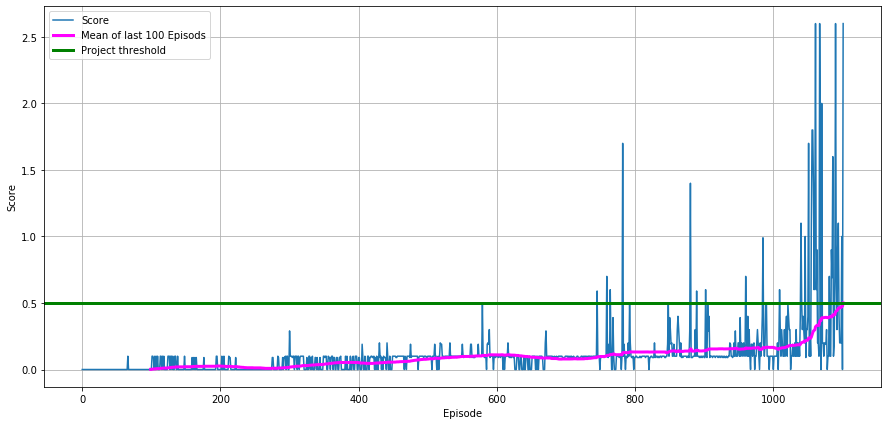

In [10]:
import pandas as pd
# plot the scores
fig = plt.figure(figsize=[15, 7])
ax = fig.add_subplot(111)

scores_mean = pd.Series(scores).rolling(100).mean()
plt.plot(np.arange(len(scores)), scores)
plt.plot(scores_mean, "-", c="magenta", linewidth=3)
plt.axhline(Param.target_score, c="green", linewidth=3)
plt.ylabel('Score')
plt.xlabel('Episode')
plt.grid(which="major")
plt.legend(["Score", "Mean of last 100 Episods", "Project threshold"])
plt.show()

## Watch the Trained Agent

In [11]:
for i, ag in enumerate(agent.agents):
    ag.actor_local.load_state_dict(torch.load(f"checkpoint_actor_agent_{i}.pth"))
    ag.critic_local.load_state_dict(torch.load(f"checkpoint_critic_agent_{i}.pth"))

In [12]:
for i in range(1, 2):                                      # play game for 1 episode
    env_info = env.reset(train_mode=False)[brain_name]     # reset the environment    
    states = env_info.vector_observations                  # get the current state (for each agent)
    scores = np.zeros(Param.num_agents)                          # initialize the score (for each agent)
    while True:
        actions = agent.act(states)                          # select an action (for each agent)
        env_info = env.step(actions)[brain_name]           # send all actions to tne environment
        next_states = env_info.vector_observations         # get next state (for each agent)
        rewards = env_info.rewards                         # get reward (for each agent)
        dones = env_info.local_done                        # see if episode finished
        scores += env_info.rewards                         # update the score (for each agent)
        states = next_states                               # roll over states to next time step
        if np.any(dones):                                  # exit loop if episode finished
            break
    print('Score (max over agents) from episode {}: {}'.format(i, np.max(scores)))

Score (max over agents) from episode 1: 0.4000000059604645


In [13]:
env.close()

### 6 Improvements
As shown in the graph above the agent did not improve very well over 1000 episodes but then the score got through the roof. By tuning the hyperparameters manually (playing arround) or automatically (as shown in the deep learing ND with sage maker) the threshold should be reachable much earlier. 
Instead of traing just in one environment at at time the training could be done on several environments in parallel with multiple agents which learn from each other. This should also lead to a less episodes of training.
As an alternative to the DDPG agent other methods like TD3 should be implemented to test if there is an improvement.